# WEEK 006 - Desicion Tree Tutorial

## 1. 使用ライブラリ
まず、以下のライブラリを使うのでインポートをする
 + numpy
 + pandas
 + matplotlib.pyplot
 + sklearn.tree.DecisionTreeClassifier 
 + sklearn.tree.export_graphviz
 + sklearn.model_selection.cross_validate (higher 0.19)
 + sklearn.model_selection.GridSearchCV
 + pydotlus
 + Ipython.display.image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import  DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pydotplus
from IPython.display import Image

## 2. データ読み込み
 + 学習データ 
   + data¥train.csv
 + テストデータ 
   + data¥test.csv

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## 3. 学習データを試しに見てみる
以下をざっくり眺める
 + 実データをちょびっと見てみる
 + 学習データの行列数
 + データの型
 + 基礎統計量
 + 欠損値の有無
 
因みにyが目的変数。
y=1は、キャンペーンに参加実績あり、
y=0は、キャンペーンに参加実績なし。

In [3]:
train.head(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1
5,6,29,blue-collar,single,secondary,no,260,yes,no,unknown,2,jun,707,14,-1,0,unknown,1
6,7,37,services,married,secondary,no,52,yes,no,cellular,6,sep,908,1,185,9,success,1
7,8,32,technician,single,secondary,no,230,yes,no,cellular,18,may,442,1,266,8,failure,1
8,9,31,admin.,single,secondary,no,0,yes,no,cellular,7,may,895,2,295,2,failure,1
9,10,32,self-employed,single,tertiary,no,1815,no,no,telephone,10,aug,235,1,102,2,failure,1


In [4]:
train.shape

(27128, 18)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
id           27128 non-null int64
age          27128 non-null int64
job          27128 non-null object
marital      27128 non-null object
education    27128 non-null object
default      27128 non-null object
balance      27128 non-null int64
housing      27128 non-null object
loan         27128 non-null object
contact      27128 non-null object
day          27128 non-null int64
month        27128 non-null object
duration     27128 non-null int64
campaign     27128 non-null int64
pdays        27128 non-null int64
previous     27128 non-null int64
poutcome     27128 non-null object
y            27128 non-null int64
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [6]:
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000
mean,13564.500000,40.951010,1355.800870,15.806215,260.711295,2.751769,40.528052,0.579733,0.117001
std,7831.323388,10.608542,3003.305272,8.337904,260.091727,3.126594,100.382462,2.503653,0.321427
min,1.000000,18.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6782.750000,33.000000,72.000000,8.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,13564.500000,39.000000,449.000000,16.000000,182.000000,2.000000,-1.000000,0.000000,0.000000
75%,20346.250000,48.000000,1428.000000,21.000000,323.000000,3.000000,-1.000000,0.000000,0.000000
max,27128.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [7]:
train.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## 4. 少し集計して踏み込んでみる
結婚の有無(maritial)とキャンペーン参加実績(y)の値を集計して見てみよう。
クロス集計を使用します。

In [8]:
train.pivot_table(index=['y'],columns=['marital'],values=['id'],aggfunc='count')

id               
marital divorced married single
y                              
0           2691   14744   6519
1            364    1667   1143

## 4.2 ちょっとめんどいクロス集計をしてみる
年齢を〜20代、３０代、４０代、５０代、６０代以上で集計した上で、yとクロス集計してみよう。
範囲を決めて集計するのをビニングと言う

In [9]:
age_bining = pd.cut(train.age,[0,20,30,40,50,60,100])
age_bining.head(10)

0     (30, 40]
1     (50, 60]
2     (30, 40]
3    (60, 100]
4     (30, 40]
5     (20, 30]
6     (30, 40]
7     (30, 40]
8     (30, 40]
9     (30, 40]
Name: age, dtype: category
Categories (6, interval[int64]): [(0, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 100]]

In [10]:
pd.crosstab(age_bining, train["y"], margins=True)

y,0,1,All
age,,,
"(0, 20]",39,21,60
"(20, 30]",3486,655,4141
"(30, 40]",9488,1111,10599
"(40, 50]",6117,602,6719
"(50, 60]",4416,488,4904
"(60, 100]",408,297,705
All,23954,3174,27128


# 5. 分類をしてみよう

## 6. 学習用データ、テストデータを取り出す
今回、
+ 目的変数は "y" 
+ 説明変数は学習用データ、テストデータの目的変数以外の全てのカラム

とする。
(hint: dummy variable)

In [11]:
y = train["y"]
trainX = pd.get_dummies(train.iloc[:,0:-1])
testX = pd.get_dummies(test.copy())

## 7. 決定木モデルを作成する
決定木モデルのパラメータには、2つ重要なものがある。
　
 + max_depth : ツリーの最大深度
 + min_samples_leaf : ツリーの葉 (ノード)　に属するサンプル数の最小
    
今回はとりあえず、max_depth = 2, min_samples_leaf = 500 で決め打ちで進める。

In [12]:
clf1 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=500)
clf1.fit(trainX, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=500, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 8. できたツリーを可視化しよう
以下のコードを実行してください。
呪文みたいなもの。

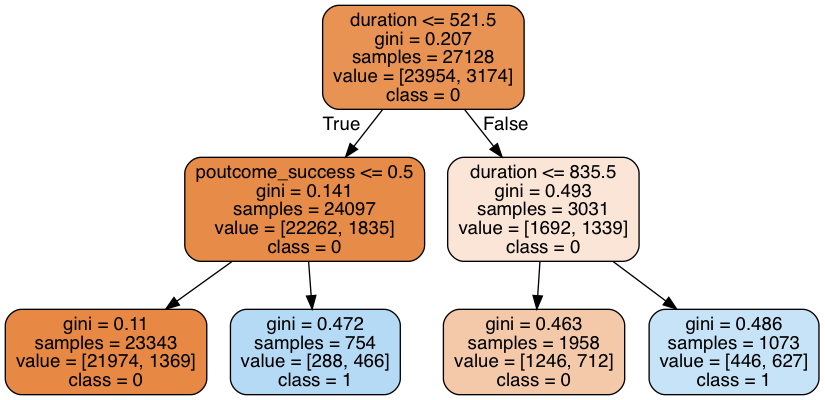

In [13]:
export_graphviz(clf1, out_file="tree.dot", feature_names=trainX.columns, class_names=["0","1"], filled=True, rounded=True)
g = pydotplus.graph_from_dot_file(path="tree.dot")
Image(g.create_png())

## 9. 予測してみよう
返却値の予測値はN行2列のマトリクスで、yが[0である確率, 1である確率]が格納されている。
(hint: predict_proba)

In [14]:
pred = clf1.predict_proba(testX)
pred

array([[ 0.41565704,  0.58434296],
       [ 0.41565704,  0.58434296],
       [ 0.94135287,  0.05864713],
       ..., 
       [ 0.94135287,  0.05864713],
       [ 0.94135287,  0.05864713],
       [ 0.94135287,  0.05864713]])

## 10. 精度を確かめよう
まだ、max_depth, min_samples_leafと言う、適当に決めたパラメータが残っている。<br>
この2つのパラメータをチューニングする必要がある。<br>
ということで、作成したモデルに対して、学習データを使って精度検証を行う。

### 今回はクロスバリデーションを使って、確認する。
###### クロスバリデーションについてはドキュメントを参照
sklearnのcross_validationメソッドを使用します。<br>
cross_validationメソッドは、データの分割と指定した評価手法での評価を一度にしてくれる。
 + 評価方法: AUC
 + 現在作成してあるモデルはfitting済みなので再作成してください。

(hint: scoring = "roc_auc")

In [15]:
clf1 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=500)
cross_validate(clf1, trainX, y, cv=5, scoring="roc_auc", n_jobs=-1) 

{'fit_time': array([ 0.10684299,  0.10799122,  0.09985209,  0.10854411,  0.046592  ]),
 'score_time': array([ 0.00833988,  0.0102818 ,  0.01002097,  0.00579786,  0.00524807]),
 'test_score': array([ 0.74657601,  0.76182968,  0.73117591,  0.73708019,  0.75909278]),
 'train_score': array([ 0.74534692,  0.74543889,  0.75305367,  0.75162308,  0.74613685])}

## 11. パラメータのチューニングをしよう
### グリッドサーチ + クロスバリデーションで最適なパラメータを探索する。
今回は簡単のために以下の条件で実施。
 + max_depth : 2 ~ 10
 + min_samples_leaf: デフォルト値何も指定しない
 
(hint1: GridSearchCVクラスを使うと指定したモデルクラスに対して探索した上でfittingしてくれる。)<br>
(hint2: GridSearchCVクラスに指定するパラメータはモデル、パラメータの範囲、評価方法)<br>
(hint3: DTクラスはパラメータなしな、プレーンな状態で作成可能)<br>
（hint4: CVはCross Varidatorの略)<br>

In [16]:
clf = DecisionTreeClassifier()
# 辞書, keywordsを要求するため
parameters = {"max_depth": list(range(2,11))}
gcv = GridSearchCV(clf, parameters, cv=5, scoring="roc_auc", n_jobs=-1)
gcv.fit(trainX, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

## 12. 結果をみてみる
結果は、グリッドサーチクラスオブジェクトのcv_results_変数に格納されている。
以下のことをしてみる。

 + 各パラメータでの評価値(auc)をプロットしてみる
    　+ ドキュメントの「実際にどのように良いパラメータを見つける？」も参照
 + 最適値を確認する
 
 (hint1: mean_train_score, mean_test_score)<br>
 (hint2: best_____params_ )

In [17]:
train_score = gcv.cv_results_["mean_train_score"]
test_score = gcv.cv_results_["mean_test_score"]
plt.plot(train_score)
plt.plot(test_score)
plt.xticks(range(-1,10), range(2,11))

([<matplotlib.axis.XTick at 0x10faf89e8>,
 <a list of 9 Text xticklabel objects>)

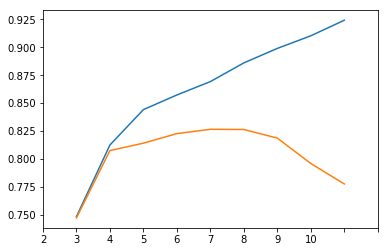

In [18]:
plt.show()

In [19]:
gcv.best_params_

{'max_depth': 6}

## 13. もう一度予測を行ってみよう
評価データを使用してもう一度予測をしてみよう。<br>
(hint: GridSearchCV.predict_proba())

In [20]:
pred = gcv.predict_proba(testX)
pred

array([[ 0.3390411 ,  0.6609589 ],
       [ 0.54751131,  0.45248869],
       [ 0.98031963,  0.01968037],
       ..., 
       [ 0.98031963,  0.01968037],
       [ 0.98031963,  0.01968037],
       [ 0.98031963,  0.01968037]])